In [1]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
import copy
import numpy as np
from timeit import default_timer
import torch.nn.functional as F
import torch.nn as nn
from utils.losses import EnergyScore, KernelScore, VariogramScore
from models.fno import FNO
from models.uno import UNO
from models.pfno import PNO_Wrapper, PFNO
from models.laplace import LA_Wrapper
from models.mcdropout import generate_mcd_samples
from data.datasets import DarcyFlowDataset, KSDataset
import cmcrameri
from matplotlib.colors import Normalize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loader for best predictions

In [2]:
batch_size = 32
n_samples = 100 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval

In [3]:
data_dir = "../../data/KS/processed/"
train_data = KSDataset(data_dir, test = False, temporal_downscaling_factor=2, init_steps = 20, pred_horizon = 20)
test_data = KSDataset(data_dir, test = True, temporal_downscaling_factor=2, init_steps = 20, pred_horizon = 20)

# Get domain and range
x,y = test_data.get_coordinates(normalize = False)
L = test_data.get_domain_range()

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

n_train = len(train_loader)
n_test = len(test_loader)

In [4]:
path = "../../results/ks_test_results/"

dropout_model = FNO(n_modes=(10,12), hidden_channels=20, in_channels = 3,dropout=0.05, lifting_channels = 128, projection_channels=128).to(device)

base_model_cp = torch.load(path+"dropout.pt", map_location=torch.device(device))
dropout_model.load_state_dict(base_model_cp)

laplace_cp = torch.load(path+"laplace.pt", map_location=torch.device(device))
laplace_model = copy.deepcopy(dropout_model)
laplace_model.load_state_dict(laplace_cp)
la_model = LA_Wrapper(laplace_model)
la_model.fit(train_loader)

pfno_model = PFNO(n_modes=(10,12), hidden_channels=20, in_channels = 3,dropout=0.05, lifting_channels = 128, projection_channels=128).to(device)
pfno_cp = torch.load(path+"sr_reparam.pt", map_location=torch.device(device))
pfno_model.load_state_dict(pfno_cp)

/scratch/buelte/anaconda3/envs/pfno/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969118/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/scratch/buelte/anaconda3/envs/pfno/lib/python3.12/site-packages/laplace/baselaplace.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.log(torch.tensor(self.sigma_noise) * sqrt(2 * pi))


<All keys matched successfully>

# Predictions

In [5]:
samples = np.random.randint(0,n_test,5)

pfno_model.train()
dropout_model.train()
""" Prediction """
pred_pfno = []
pred_dropout = []
pred_la = []

with torch.no_grad():    
    index = 0
    for sample in samples:
        a,u = test_data.__getitem__(sample)
        a = a.to(device).unsqueeze(0)
        u = u.to(device).unsqueeze(0)
        dropout_pred = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        pfno_pred = pfno_model(a, n_samples = n_samples)
        la_pred = la_model.predictive_samples(a)

        pred_dropout.append( dropout_pred )
        pred_pfno.append( pfno_pred )
        pred_la.append( la_pred )


pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()
pred_la = torch.cat(pred_la, dim = 0).cpu().numpy()

In [6]:
# Plot function should get
# truth, predictions of one sample, names, grid, and save_path

In [7]:
idx = 0

a,u = test_data.__getitem__(samples[idx])
a = a.unsqueeze(0).numpy()
u = u.unsqueeze(0).numpy()

preds = [pred_dropout[idx],pred_la[idx], pred_pfno[idx]]
names = ['Dropout','LA', 'PFNO']

In [8]:
def plot_statistics(truth, preds, names, grid, save_path = None, alpha = 0.05):
    n_models = len(preds)
    x,y = grid


    # Get scalings
    pred_array = np.array(preds)
    mse_norm = Normalize(vmin = 0, vmax = np.power(truth - pred_array.mean(axis = -1),2).max())
    std_norm = Normalize(vmin = 0, vmax = pred_array.std(axis = -1).max())
    

    fig, axs = plt.subplots(3,n_models, figsize = (15, 8), subplot_kw=dict(box_aspect=0.6),
                         sharex=True, sharey=True)
    for m, pred in enumerate(preds):
        truth = truth.squeeze()
        pred = pred.squeeze()
        # Calculate coverage
        q_lower = np.quantile(pred,alpha/2, axis = -1)
        q_upper = np.quantile(pred,1-alpha/2, axis = -1)
        coverage = (truth>q_lower) & (truth<q_upper)
        im1 = axs[0,m].pcolormesh(x,y,np.power(truth - pred.mean(axis = -1),2), shading = "nearest", cmap = "cmc.vik", norm = mse_norm)
        im2 = axs[1,m].pcolormesh(x,y,pred.std(axis = -1), shading = "nearest", cmap = "cmc.lajolla", norm = std_norm)
        im3 = axs[2,m].pcolormesh(x,y,coverage, shading = "nearest")
        axs[0,m].set_title(names[m])
    fig.colorbar(im1, ax = axs[0,m])
    fig.colorbar(im2, ax = axs[1,m])
    fig.colorbar(im3, ax = axs[2,m])

    axs[0,0].set_ylabel('Mean squared error')
    axs[1,0].set_ylabel('Standard deviation')
    axs[2,0].set_ylabel('Coverage (95%)')
    fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi = 300)
    
    plt.show()

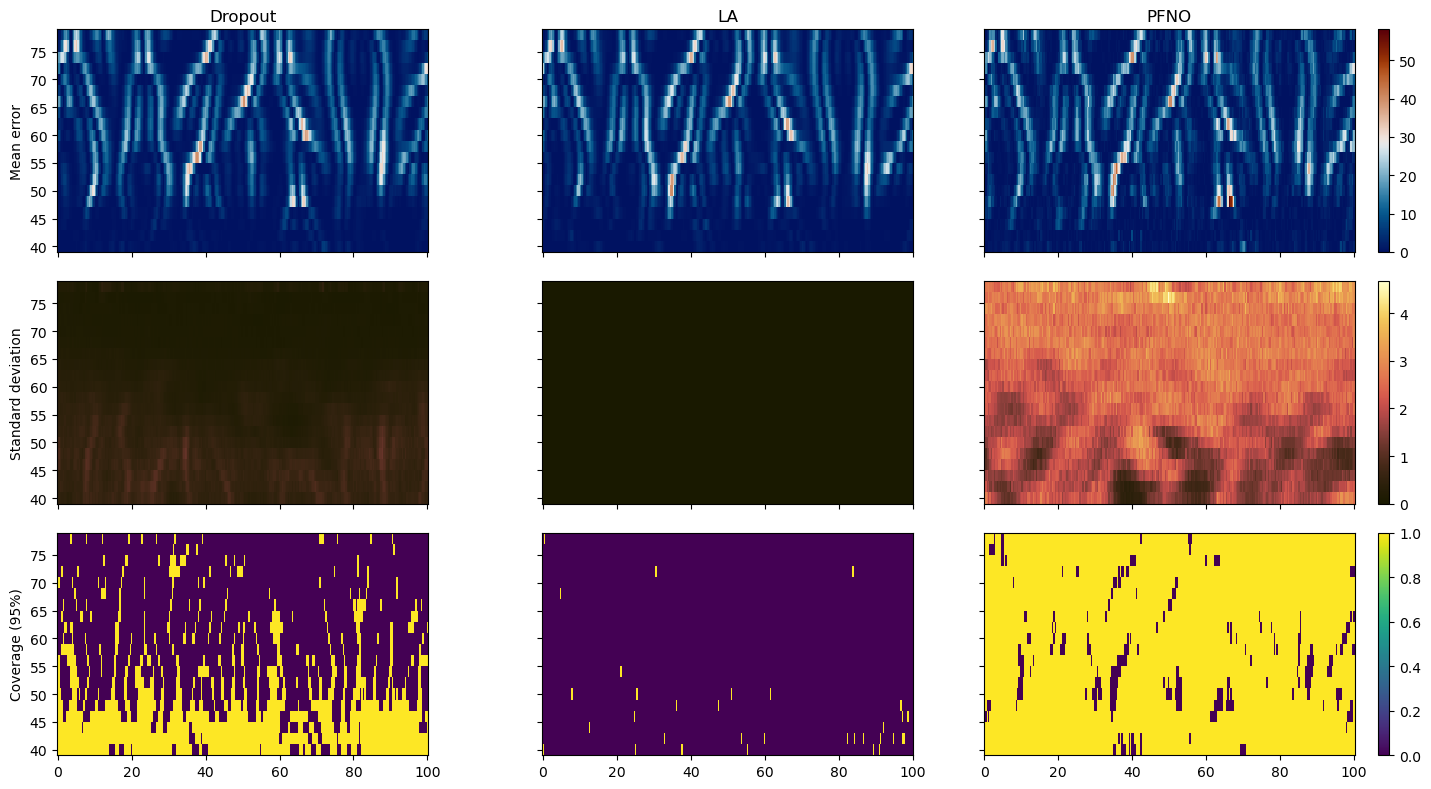

In [9]:
plot_statistics(u, preds, names, (x,y), save_path = "ks/ks_statistics.png")

In [10]:
def plot_predictions(truth, preds, names, grid, save_path = None, alpha = 0.05):
    n_models = len(preds)
    x,y = grid

    fig, axs = plt.subplots(4, n_models, figsize = (15, 10), subplot_kw=dict(box_aspect=0.6),
                         sharex=True, sharey=True)
    for m, pred in enumerate(preds):
            truth = truth.squeeze()
            pred = pred.squeeze()
            im1 = axs[0,m].pcolormesh(x,y,truth, shading = "nearest", cmap = "cmc.roma_r")
            im2 = axs[1,m].pcolormesh(x,y,pred.mean(axis = -1), shading = "nearest", cmap = "cmc.roma_r")
            im3 = axs[2,m].pcolormesh(x,y,pred.std(axis = -1), shading = "nearest", cmap = "cmc.lajolla")
            # Calculate coverage
            q_lower = np.quantile(pred,alpha/2, axis = -1)
            q_upper = np.quantile(pred,1-alpha/2, axis = -1)
            coverage = (truth>q_lower) & (truth<q_upper)
            im4 = axs[3,m].pcolormesh(x,y,coverage, shading = "nearest")
            axs[0,m].set_title(names[m])

    fig.colorbar(im1, ax = axs[0,m])
    fig.colorbar(im2, ax = axs[1,m])
    fig.colorbar(im3, ax = axs[2,m])
    fig.colorbar(im4, ax = axs[3,m])

    axs[0,0].set_ylabel('Ground truth')
    axs[1,0].set_ylabel('Mean prediction')
    axs[2,0].set_ylabel('Standard deviation')
    axs[3,0].set_ylabel('Coverage (95%)')
    fig.tight_layout()

    if save_path is not None:
        plt.savefig(save_path)
    
    plt.show()

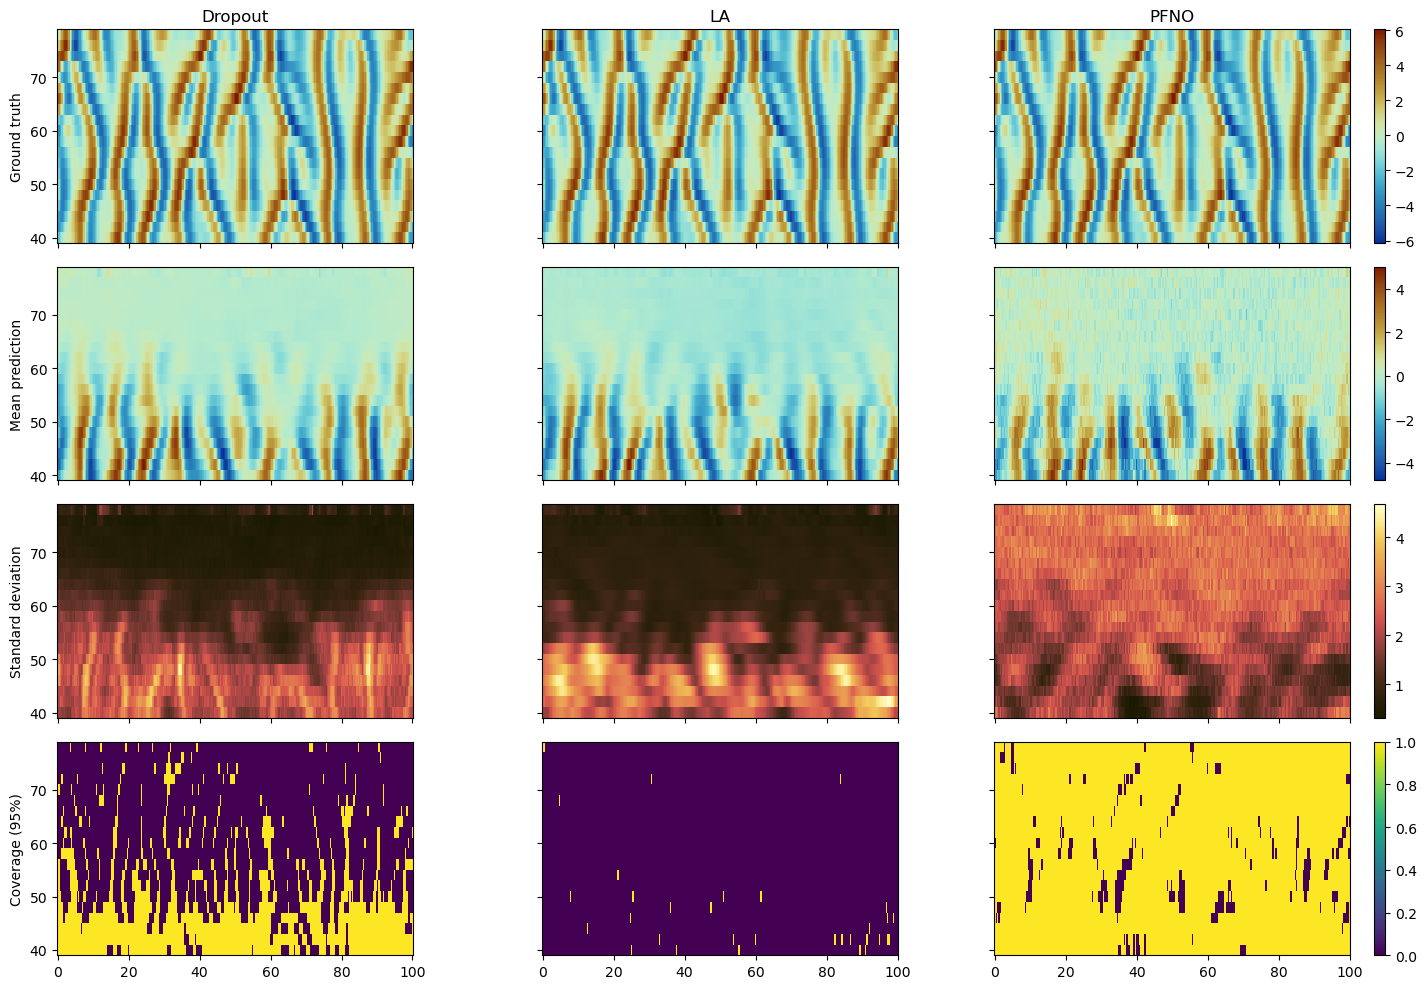

In [11]:
plot_predictions(u, preds, names, (x,y))

# Plot

In [12]:
idx = 0

a,u = test_data.__getitem__(samples[idx])
a = a.unsqueeze(0).numpy()
u = u.unsqueeze(0).numpy()

preds = [pred_dropout[idx],pred_la[idx], pred_pfno[idx]]
names = ['Dropout','LA', 'PFNO']

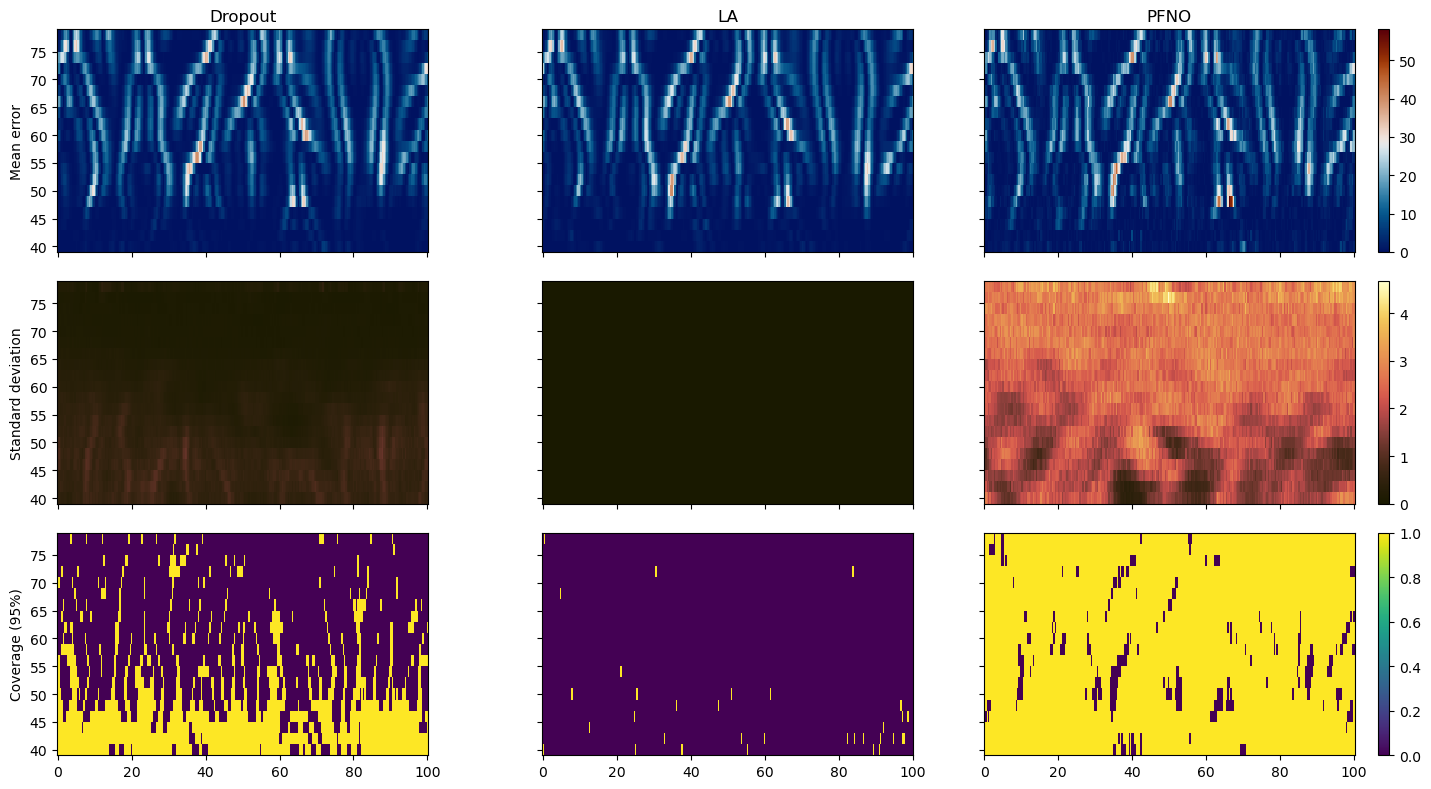

In [13]:
plot_statistics(u, preds, names, (x,y))

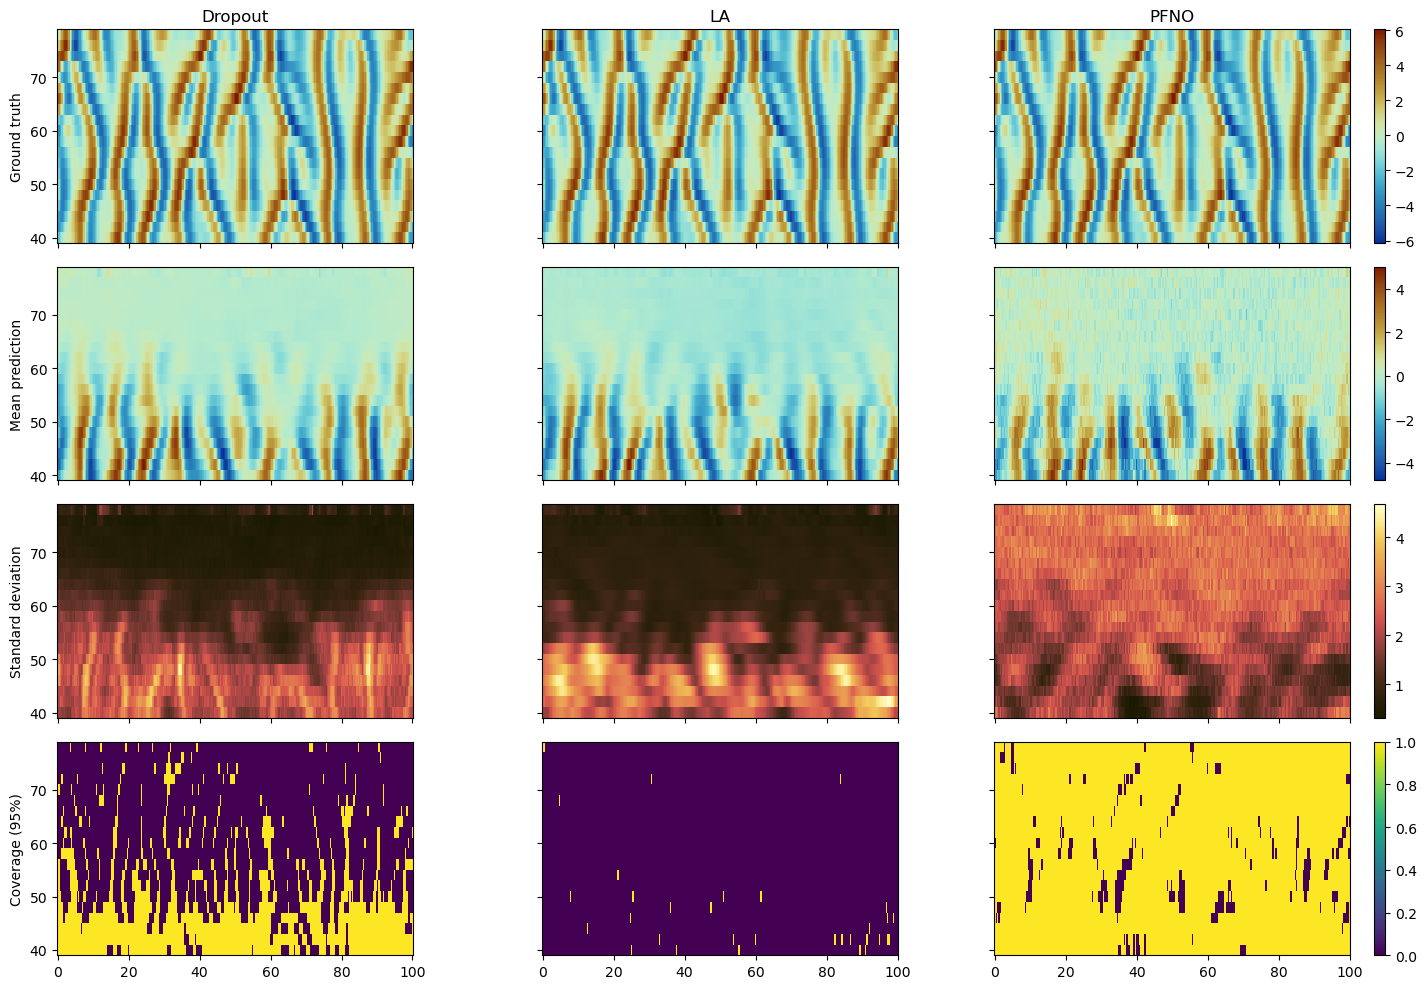

In [14]:
plot_predictions(u, preds, names, (x,y))